In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer
import re
import string
import inflect
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
#import database
df = pd.read_csv("IMDB Dataset Cleaned.csv")
df = df[['cleaned_review', 'sentiment']]

In [4]:
#replace positive with 1 and negative with 0
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})

# **LSTM**

In [5]:
#LSTM with Keras tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenize the text data
max_words = 10000  # Maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df['cleaned_review'])
X = tokenizer.texts_to_sequences(df['cleaned_review'])
X = pad_sequences(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=42)


In [6]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [8]:
import tensorflow as tf
# Define a callback to print loss and metrics during training
class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{epochs} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

# Train the model and capture the history
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[PrintMetricsCallback()])


Epoch 1/10
625/625 [==============================] - 132s 199ms/step - loss: 0.3542 - accuracy: 0.8444 - val_loss: 0.2853 - val_accuracy: 0.8841
Epoch 2/10
625/625 [==============================] - 59s 94ms/step - loss: 0.2207 - accuracy: 0.9154 - val_loss: 0.2885 - val_accuracy: 0.8800
Epoch 3/10
625/625 [==============================] - 51s 81ms/step - loss: 0.1719 - accuracy: 0.9359 - val_loss: 0.3229 - val_accuracy: 0.8757
Epoch 4/10
625/625 [==============================] - 41s 66ms/step - loss: 0.1344 - accuracy: 0.9510 - val_loss: 0.3201 - val_accuracy: 0.8717
Epoch 5/10
625/625 [==============================] - 37s 59ms/step - loss: 0.1081 - accuracy: 0.9624 - val_loss: 0.3707 - val_accuracy: 0.8818
Epoch 6/10
625/625 [==============================] - 38s 61ms/step - loss: 0.0833 - accuracy: 0.9717 - val_loss: 0.4539 - val_accuracy: 0.8767
Epoch 7/10
625/625 [==============================] - 34s 54ms/step - loss: 0.0683 - accuracy: 0.9771 - val_loss: 0.4497 - val_accurac

In [9]:
# Plot the training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

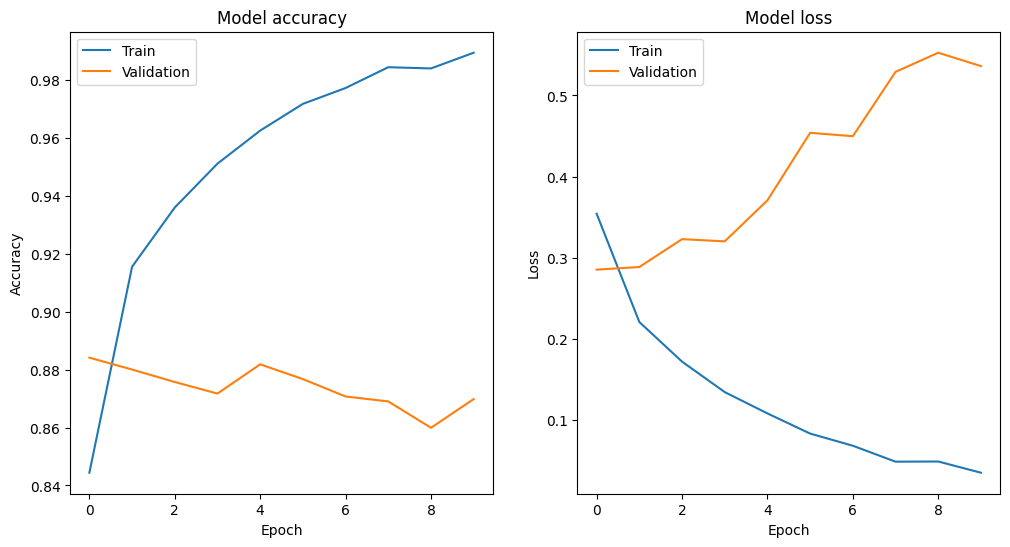

In [10]:
# Plot the training history
plot_training_history(history)

In [11]:
# Evaluate the model on the test set using accuracy and loss and sklearn classification report
from sklearn.metrics import classification_report
score = model.evaluate(X_test, y_test, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


313/313 [==============================] - 5s 17ms/step - loss: 0.5361 - accuracy: 0.8698
Loss: 0.5361, Accuracy: 0.8698


In [14]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Generate predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5)  # Assuming a binary classification threshold of 0.5

# Classification report
print('Classification Report:\n', classification_report(y_test, predictions))

# Accuracy score in percentage
accuracy_percent = accuracy_score(y_test, predictions) * 100
print(f'Accuracy Score: {accuracy_percent:.2f}%')


313/313 [==============================] - 6s 18ms/step - loss: 0.5361 - accuracy: 0.8698
Loss: 0.5361, Accuracy: 0.8698
313/313 [==============================] - 5s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy Score: 86.98%


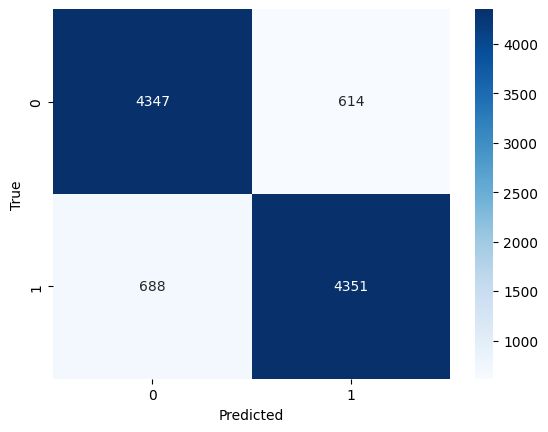

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()